In [62]:
from tqdm import tqdm
from video_utils import *
from anns import *
import pickle
from sklearn.cluster import KMeans


In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:

with open("colors.pkl", "rb") as f:
    colors = pickle.load(f)

with open("detection.pkl", "rb") as f:
    detection = pickle.load(f)

with open("image.pkl", "rb") as f:
    image = pickle.load(f)


In [65]:

colors = colors.reshape(colors.shape[:2])

kmeans = KMeans(n_clusters=2, random_state=0).fit(colors)
kmeans.fit(colors)
# get the cluster of the detection color
x2, y2 = detection.rect.bottom_right.int_xy_tuple
x1, y1 = detection.rect.top_left.int_xy_tuple
crop = image[y1:y2, x1:x2]
b, g, r = cv2.mean(crop)[:3]
detection_color = np.array([r, g, b]).reshape(1, 3)


detection_cluster = kmeans.predict(detection_color)

print(detection_cluster)

[0]


/home/fer/miniconda3/envs/futstats/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/fer/miniconda3/envs/futstats/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [66]:
kmeans.cluster_centers_[detection_cluster[0]]

array([     122.02,      157.11,      102.57])

In [67]:
kmeans.cluster_centers_

array([[     122.02,      157.11,      102.57],
       [     140.36,      161.32,       137.9]])

In [68]:
other_cluster =  kmeans.cluster_centers_[0 if detection_cluster[0] == 1 else 1]
other_cluster

array([     140.36,      161.32,       137.9])

In [69]:
kmeans.cluster_centers_

array([[     122.02,      157.11,      102.57],
       [     140.36,      161.32,       137.9]])

In [74]:
from posession_utils import *


In [77]:
posession_pipeline = PosessionPipeline()

curr_color_in_posession = posession_pipeline.cluster_color(
    image=None,
    detection=[],
)

curr_color_in_posession

(None, None)

In [78]:
## load team_colors from pickle
with open("team_colors.pkl", "rb") as f:
    team_colors = pickle.load(f)
    

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

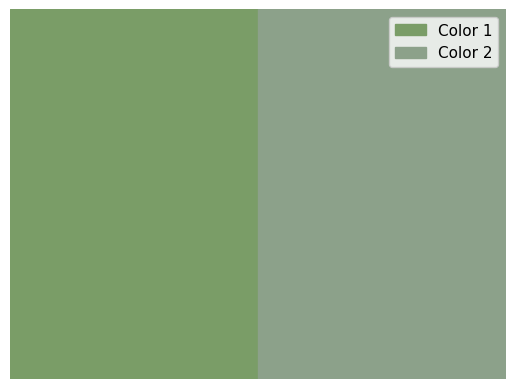

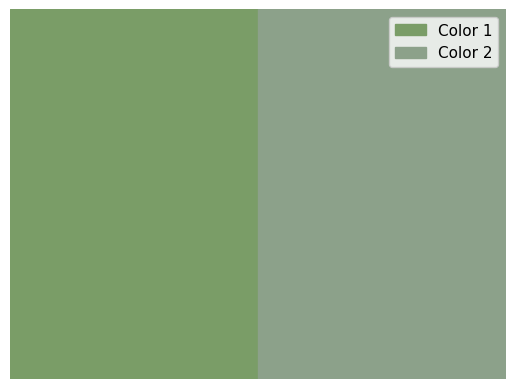

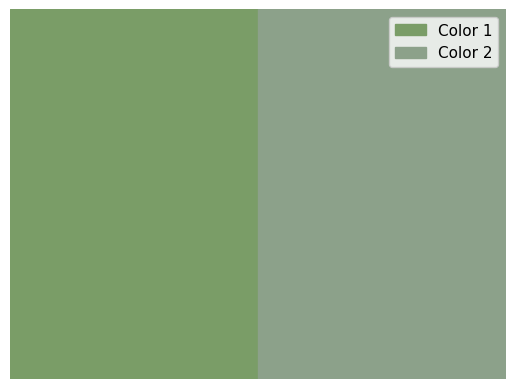

In [85]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot a rectangle filled with color1
ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=[c / 255 for c in team_colors["1"].to_array()], label='Color 1'))

# Plot a rectangle filled with color2
ax.add_patch(plt.Rectangle((1, 0), 1, 1, color=[c / 255 for c in team_colors["2"].to_array()], label='Color 2'))

# Set axis limits
ax.set_xlim(0, 2)
ax.set_ylim(0, 1)

# Remove axis labels and ticks
ax.axis('off')

# Add a legend
ax.legend()

# Display the colors
plt.show()

In [2]:
from PIL import Image

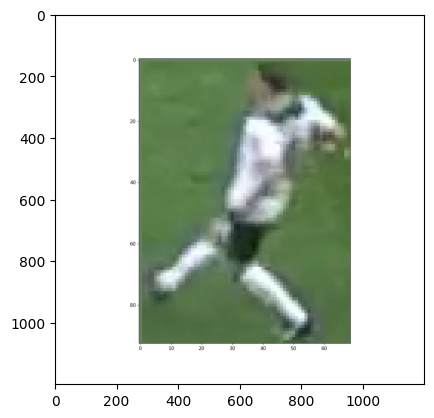

In [72]:
## read image.png image
image = np.array(Image.open("image_white.png"))

plt.imshow(image)

In [7]:
import numpy as np
import cv2
from video_utils import plot_image
from PIL import Image
import matplotlib.pyplot as plt

(369, 496, 4)


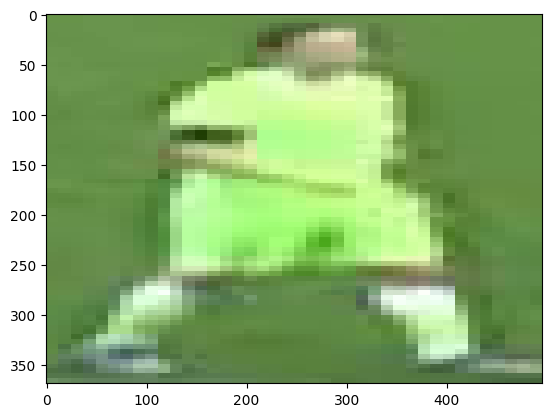

In [83]:
image = "crop"

image = np.array(Image.open(f"{image}.png", "r"))

print(image.shape)
plt.imshow(image)

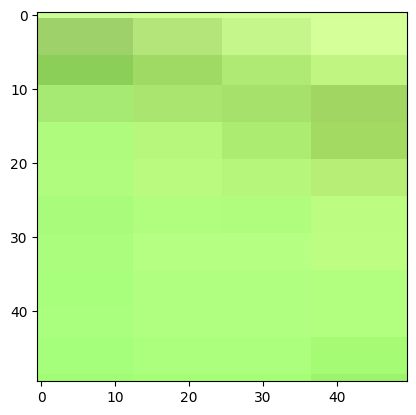

In [106]:

h = int(image.shape[0] / 2)
w = int(image.shape[1] / 2)
center_crop = image[h -25 : h + 25, w -25 :w + 25, :]

plt.imshow(center_crop)

In [101]:
# get pixel color at center of image
r,g,b = cv2.mean(image[int(h) : int(h) + 25, int(w): int(w) + 25, :])[:3]
print(b, g, r)

125.9616 253.83040000000003 177.5216


In [102]:
color = np.array([r, g, b]).reshape(1, 3)
color

array([[177.5216, 253.8304, 125.9616]])

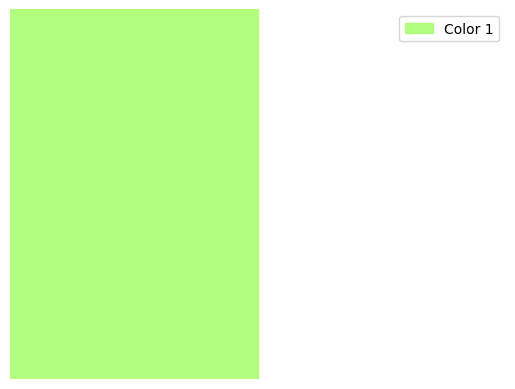

In [103]:
fig, ax = plt.subplots()

ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=[c / 255 for c in color[0]], label='Color 1'))

ax.set_xlim(0, 2)
ax.set_ylim(0, 1)

ax.axis('off')

ax.legend()

plt.show()

## HSV

In [82]:
import cv2
import numpy as np

def get_shirt_color(roi):
    # Convert the ROI to the HSV color space
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Define color ranges for different shirt colors
    color_ranges = {
        'red': [(0, 50, 50), (10, 255, 255)],  # Red color range
        'blue': [(100, 50, 50), (130, 255, 255)],  # Blue color range
        'yellow': [(20, 50, 50), (40, 255, 255)],  # Yellow color range
        'green': [(50, 50, 50), (70, 255, 255)],  # Green color range
        'orange': [(5, 50, 50), (15, 255, 255)],  # Orange color range
        'white': [(0, 0, 255), (0, 0, 255)],  # White color range
        'black': [(0, 0, 0), (0, 0, 0)]  # Black color range
        # Add more color ranges as needed
    }

    color_counts = {}

    for color_name, (lower, upper) in color_ranges.items():
        # Create a mask using the defined color range
        mask = cv2.inRange(hsv_roi, np.array(lower), np.array(upper))

        # Count the number of pixels in the mask
        pixel_count = cv2.countNonZero(mask)
        color_counts[color_name] = pixel_count

    # Determine the dominant shirt color
    dominant_color = max(color_counts, key=color_counts.get)
    confidence = (color_counts[dominant_color] / roi.size) * 100  # Confidence as a percentage

    return dominant_color, confidence

# Load and preprocess an image
image = cv2.imread("crop.png")

# Crop the ROI using the bounding box (x, y, w, h)
x, y, w, h = (100, 200, 150, 300)  # Replace with your bounding box coordinates
roi = image[y:y+h, x:x+w]
#roi = image[200:1000,400:800,:]
# Get the shirt color and confidence
shirt_color, confidence = get_shirt_color(roi)

print(f"The dominant shirt color is {shirt_color} with {confidence:.2f}% confidence.")


The dominant shirt color is green with 16.95% confidence.


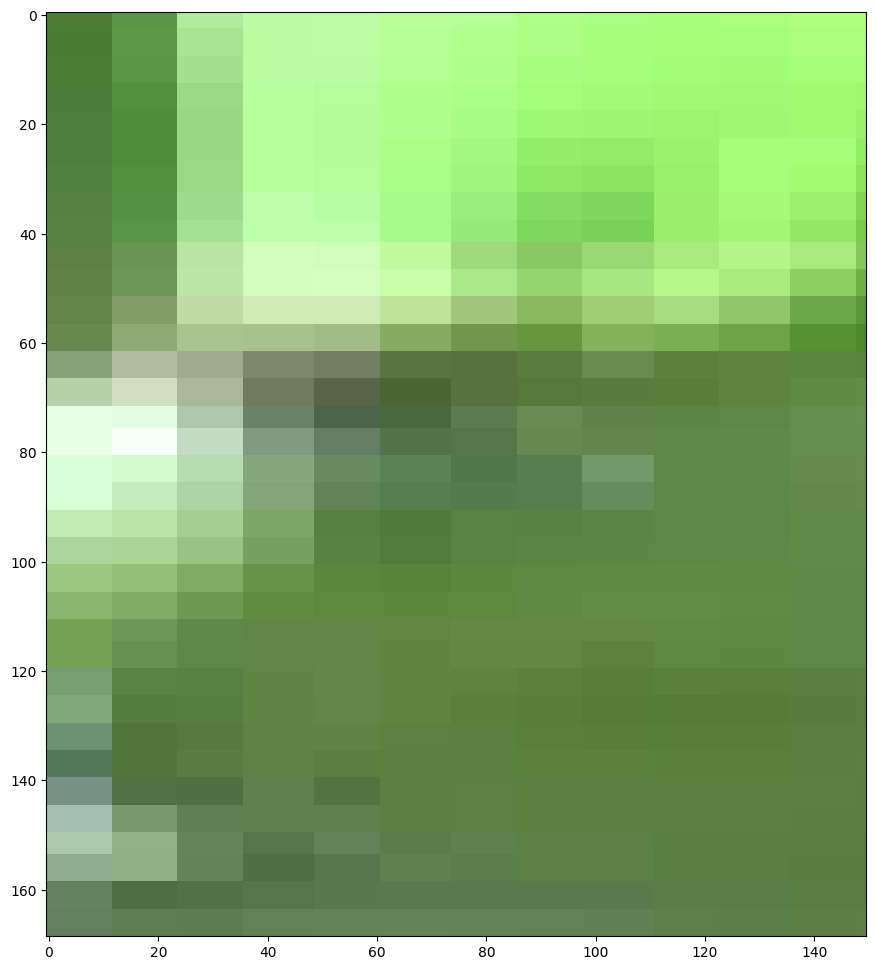

In [81]:
plot_image(roi)

In [112]:
from typing import Dict, List
from anns import Detection, Color

In [134]:
def vote_color(colors: List[Color]) -> Color:
    ## get the most common color
    print(set(colors))
    print(colors.count)
    color = max(set(colors), key=colors.count)
    return color

In [135]:
color1 = Color(2, 2, 2)
color2 = Color(2, 2, 2)
color3 = Color(1, 1, 1)